<h1><center><strong> Stock Market Predictor Tool</strong></center></h1>

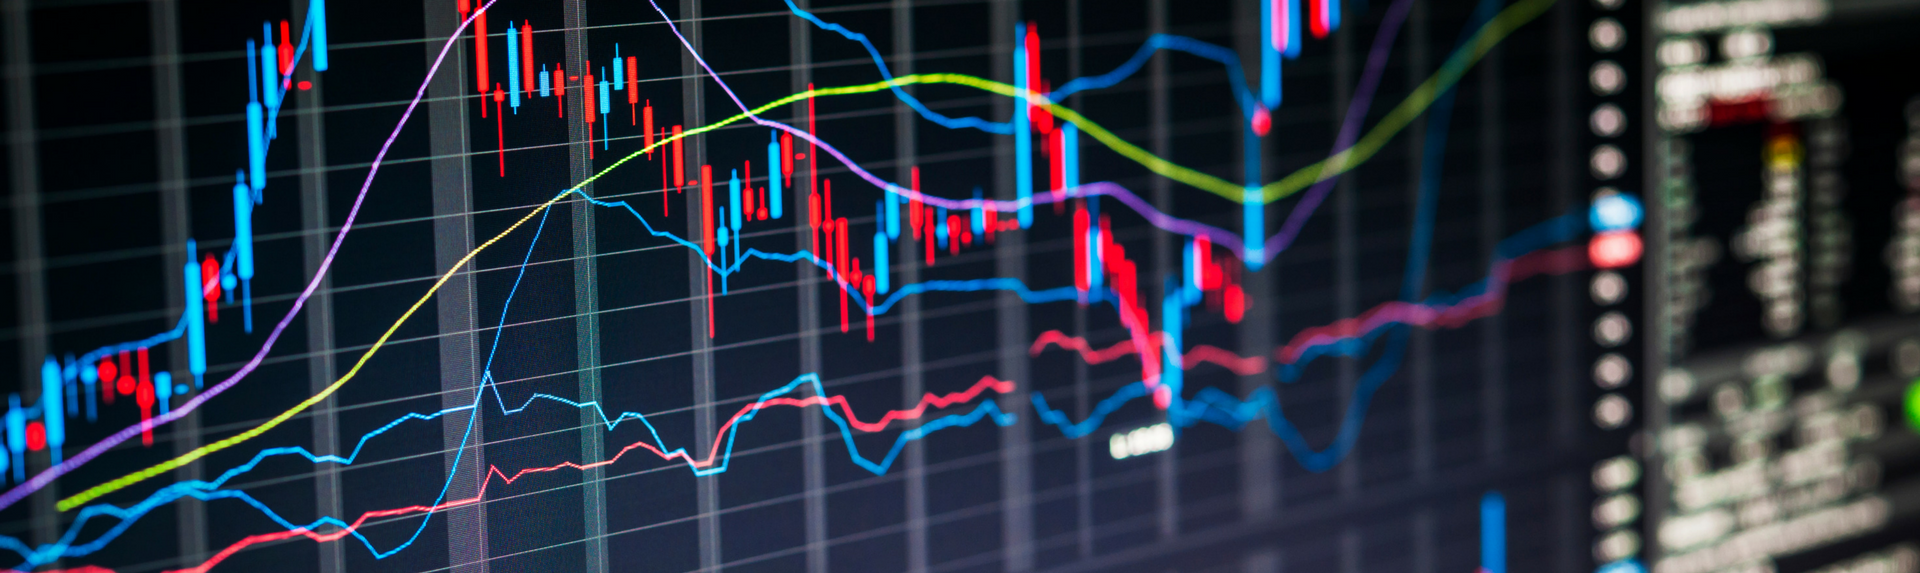

Background - Why do this?

I have been investing in the stock market over the last couple of years.  This year with the Covid 19 Pandemic - there has been bloodbath across the Indian stock market, however there are multiple stocks which have managed to prosper during this time.  My idea was to create a tool which would allow me to understand for the short term say between 7 days to 90 days how a particular stock would fare.  Such that I can make better informed judgment on whether to hold or sell the stock.  Also in the case of new information received on expected high performing stocks - be able to make a better than average market profits from the same.

Inputs needed:
- Get today's date
- Get full list of all stock names
- Predict the stock price using different methods including ARIMA
- Model evaluation on predicted stock prices

Table of Contents:
___

1. [Setup](#Section1)<br><br>
2. [Using NSEPy to extract data](#Section2)<br><br>
3. [EDA on Downloaded Data](#Section3)<br><br>
4. [Seasonal Decomposition](#Section4)<br><br>
5. [Checking on Original Dataset](#Section5)<br><br>
6. [Data Transformation with Logscale](#Section6)<br><br>
7. [Moving average transformation](#Section7)<br><br>
8. [Exponential Decay Transformation](#Section8)<br><br>
9. [Logscale Minus Moving Average Transformation](#Section9)<br><br>
10. [Time Shift Transformation](#Section10)<br><br>
11. [Plotting ACF and PACF](#Section11)<br><br>
12. [Building Models](#Section12)<br>
    12.1 [AR Model](#Section1201)<br>
    12.2 [ARMA Model](#Section1202)<br>
    12.3 [ARIMA Model](#Section1203)<br><br>
13. [Prediction and reverse transformation of fitted values](#Section13)<br><br>
14. [Approach 2 for model building - using Gridsearch](#Section14)<br><br>
15. [Approach 3 for model building -  using Facebook Prophet](#Section15)<br>
    15.1 [Prediction](#Section1501)<br>
    15.2 [Model Evaluation](#Section1502)<br><br>
16. [Conclusions & Way Forward](#Section16)<br><br>

<a id = Section1></a>
# **1. Set-up**

In [1]:
import pandas as pd
import numpy as np
from pandas import Grouper
import matplotlib.pyplot as plt
%matplotlib inline

from nsetools import Nse
from nsepy import get_history
import yfinance as yf

from datetime import date

#getting today's date for data extraction
today = date.today()
print(today)

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize']  =  20, 7

2020-11-26


In [2]:
#getting full list of all stock prices from nsepy - 'SYMBOL': 'NAME OF COMPANY'
#for use when predicting across all stocks
all_stock_codes = pd.DataFrame(list(Nse().get_stock_codes().items()))  
    #converting the data to dictionary list & converting to dataframe
header = all_stock_codes.iloc[0]  #picking up the first row of the data containing the haders to variable header
all_stock_codes = all_stock_codes[1:]  # picking up all the data without the 1st row
all_stock_codes.columns = header  # inserting the data from header into dataframe
all_stock_codes.head()

0      SYMBOL                           NAME OF COMPANY
1   20MICRONS                        20 Microns Limited
2  21STCENMGM  21st Century Management Services Limited
3  3IINFOTECH                       3i Infotech Limited
4     3MINDIA                          3M India Limited
5      3PLAND                  3P Land Holdings Limited

<a id = Section2></a>
# 2. Using nsepy to extract data

In [3]:
#using sample data from NSEpy - yahoofinance seems to be giving incorrect data
Year, Month, Day = today.year , today.month , today.day   #splitting datetime into individual components for dataset.
data = get_history(symbol= 'ACC', start=date(2010,1,1), end=date(Year,Month,Day))
data.head()

Symbol Series  Prev Close    Open   High     Low    Last   Close  \
Date                                                                          
2010-01-04    ACC     EQ      872.45  870.00  920.0  870.00  919.10  913.60   
2010-01-05    ACC     EQ      913.60  920.55  926.4  898.05  901.00  901.75   
2010-01-06    ACC     EQ      901.75  904.50  912.5  895.35  910.15  907.60   
2010-01-07    ACC     EQ      907.60  910.00  926.0  905.65  914.00  913.35   
2010-01-08    ACC     EQ      913.35  917.70  924.7  907.60  911.60  912.15   

              VWAP  Volume      Turnover  Trades  Deliverable Volume  \
Date                                                                   
2010-01-04  898.90  852434  7.662531e+13     NaN              267171   
2010-01-05  913.48  439209  4.012085e+13     NaN              103115   
2010-01-06  904.48  517109  4.677131e+13     NaN              153415   
2010-01-07  917.84  403862  3.706825e+13     NaN              118497   
2010-01-08  915.66  284905  2.608761e+13     NaN              100433   

            %Deliverble  
Date                     
2010-01-04       0.3134  
2010-01-05       0.2348  
2010-01-06       0.2967  
2010-01-07       0.2934  
2010-01-08       0.3525

<a id = Section3></a>
# 3. EDA on Downloaded Data

In [4]:
#manipulating the downloaded dataset for further anlysis
X = data.reset_index()  #reseting index of the downloaded data
X = X[['Date','Close']]  #selecting only the specific columns to the dataframe
X.Date = pd.to_datetime(X.Date, infer_datetime_format=True)  # making the date column datetime readable
Xindex = X.set_index(['Date'])     #setting the date index
Xindex = Xindex.resample('D').mean().ffill() #filling in all holidays
Xindex   # a quick check on how the output looks

Close
Date               
2010-01-04   913.60
2010-01-05   901.75
2010-01-06   907.60
2010-01-07   913.35
2010-01-08   912.15
...             ...
2020-11-21  1686.80
2020-11-22  1686.80
2020-11-23  1725.55
2020-11-24  1696.60
2020-11-25  1664.75

[3979 rows x 1 columns]

In [5]:
Xindex.shape

(3979, 1)

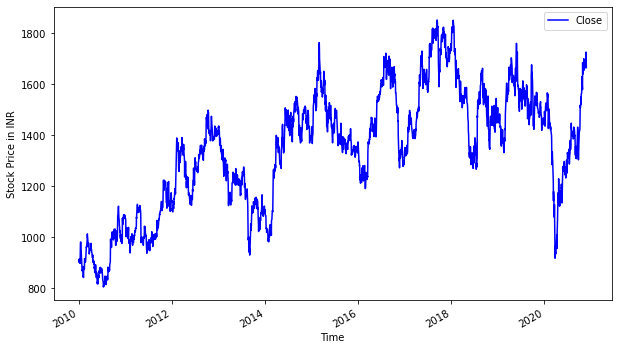

In [6]:
X.plot(x='Date',y = 'Close', color = 'b', figsize = (10,6))
plt.ylabel('Stock Price in INR')
plt.xlabel('Time');

In [7]:
Xindex.describe()

Close
count  3979.000000
mean   1342.618246
std     238.136208
min     805.450000
25%    1158.850000
50%    1375.000000
75%    1516.700000
max    1851.250000

As on 28th September for ACC:
- The mean for this stock is around 1,337 with a standard deviation of 238 - around 18%.
- The mean is slightly lower than 50% indicating the median and average are relatively nearby.
    - Also indicating that there is growth on the stock - so datatransformation would be needed.

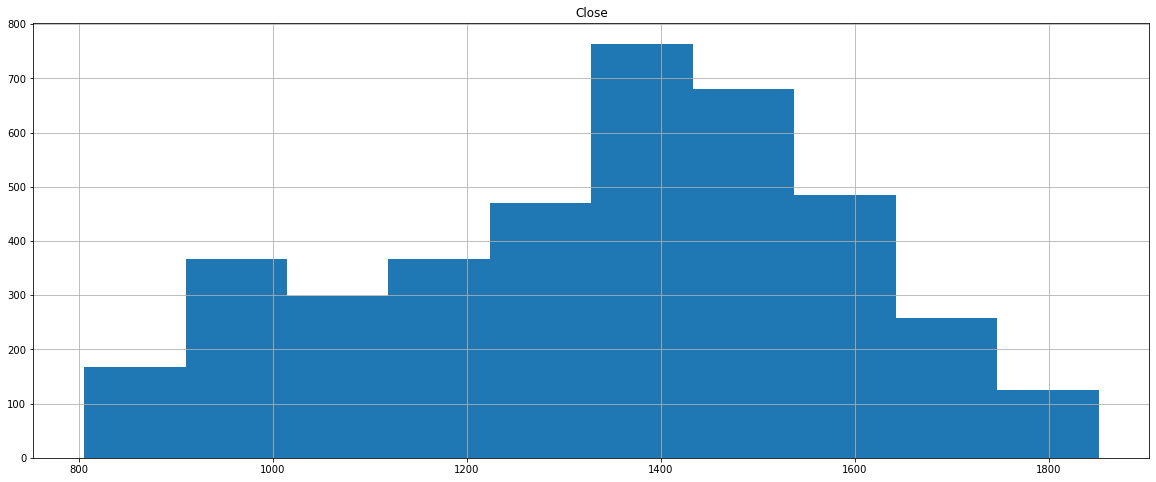

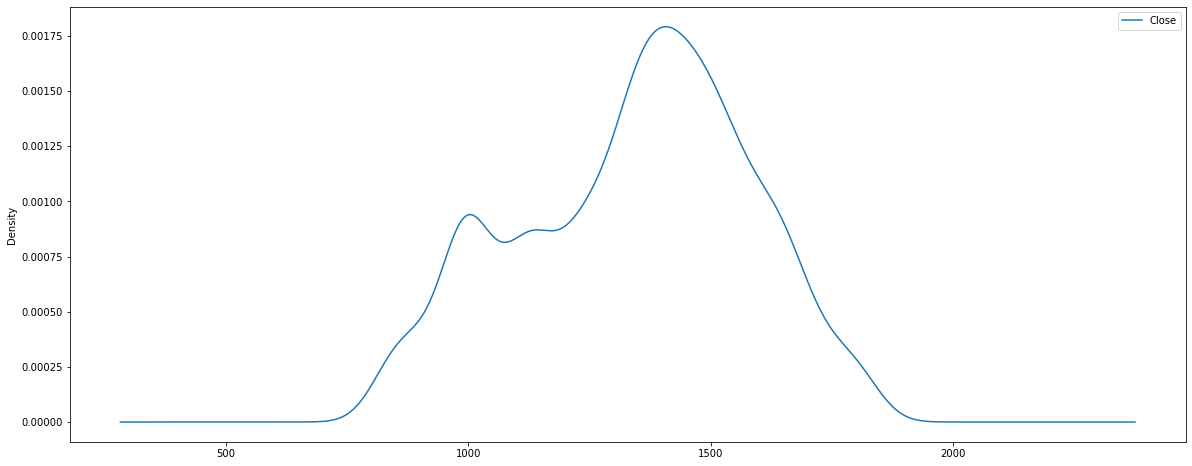

In [8]:
Xindex.hist(figsize = (20,8))
Xindex.plot(kind = 'kde', figsize = (20,8));

The distribution seems to be largely Gaussian, and right shifted.

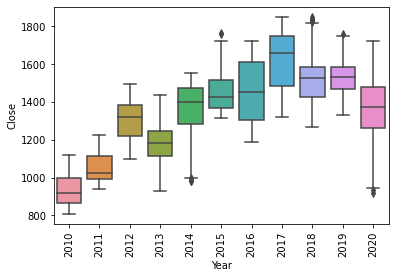

In [9]:
import seaborn as sns

X2 = X.copy()  #creating a copy of the original dataframe

X2['Year'] = pd.DatetimeIndex(X2['Date']).year  # creating a year column in the X2 dataframe

ax = sns.boxplot(data = X2, x='Year',y='Close')  # creating the boxplot
for item in ax.get_xticklabels():
    item.set_rotation(90)

<a id = Section4></a>
# 4. Seasonal Decomposition

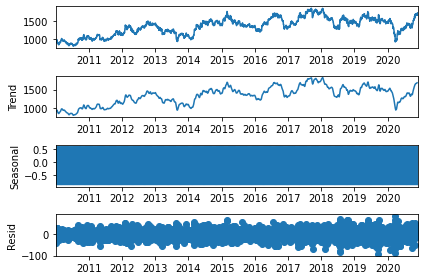

In [10]:
decomposition = seasonal_decompose(Xindex, period = 12)
figure = decomposition.plot();

In [11]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  '{:f}'.format(values)
    print(output)

<a id = Section5></a>
# 5. Checking on original dataset

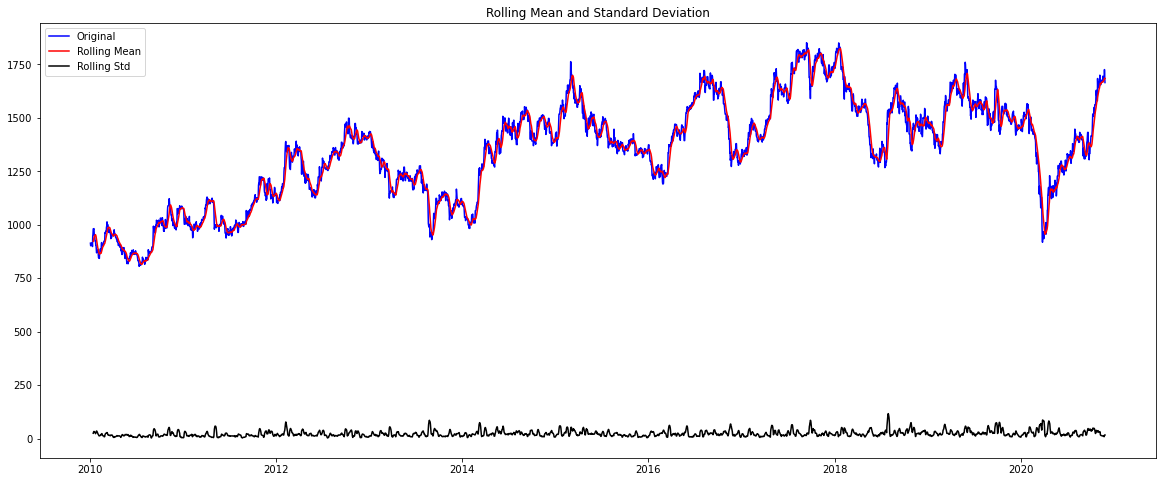

Results of dickey fuller test
Test Statistics                 -2.57873
p-value                        0.0974741
No. of lags used                       1
Number of observations used         3977
critical value (1%)            -3.431995
critical value (5%)            -2.862267
critical value (10%)           -2.567157
dtype: object


In [12]:
test_stationarity(Xindex)

<a id = Section6></a>
# 6. Data Transformation with Logscale

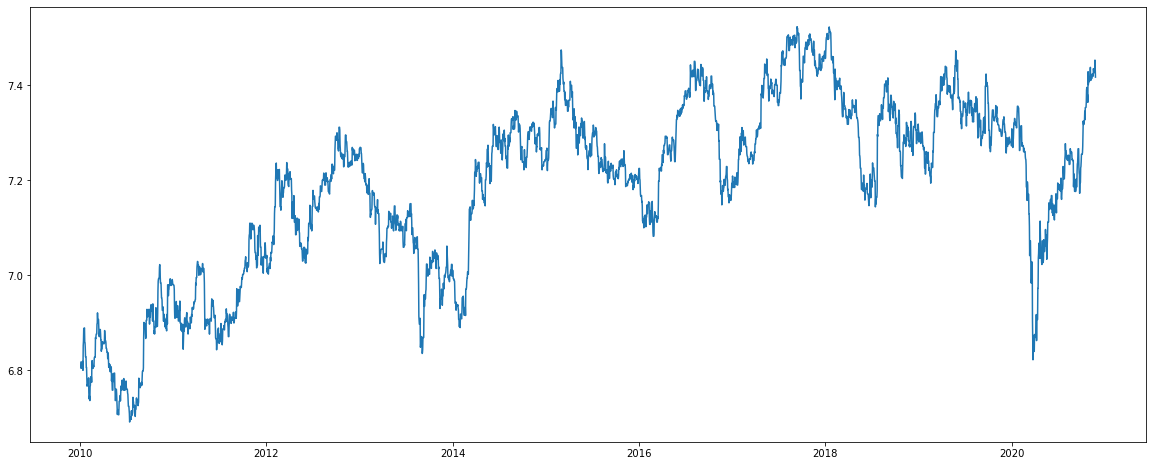

In [13]:
X_index_logscale = np.log(Xindex)
plt.figure(figsize=(20,8))
plt.plot(X_index_logscale)

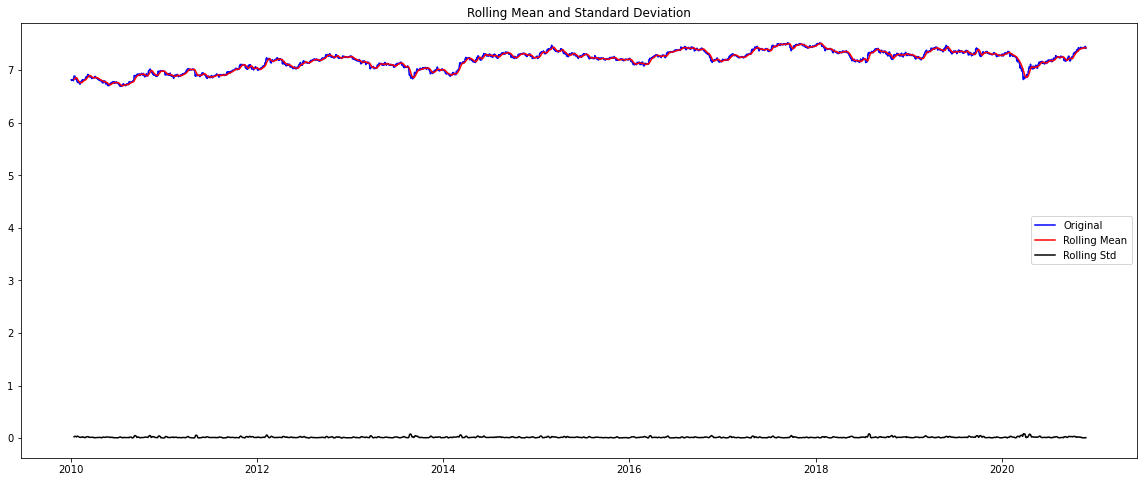

Results of dickey fuller test
Test Statistics                 -2.60507
p-value                         0.091954
No. of lags used                       0
Number of observations used         3978
critical value (1%)            -3.431995
critical value (5%)            -2.862267
critical value (10%)           -2.567157
dtype: object


In [14]:
test_stationarity(X_index_logscale)

A bit closer than without log transformation - lets try another transformation method

<a id = Section7></a>
# 7. Moving average transformation

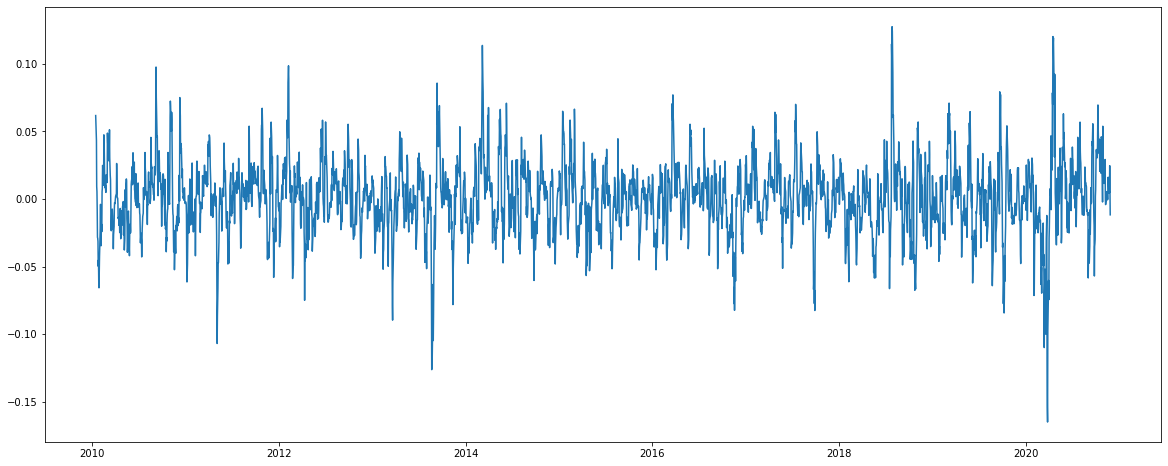

In [15]:
X_moving_average = X_index_logscale.rolling(window = 12).mean()
X_logscale_minus_moving_average = X_index_logscale - X_moving_average

plt.figure(figsize=(20,8))
plt.plot(X_logscale_minus_moving_average)

#need to remove nan from the data set
X_logscale_minus_moving_average.dropna(inplace = True)

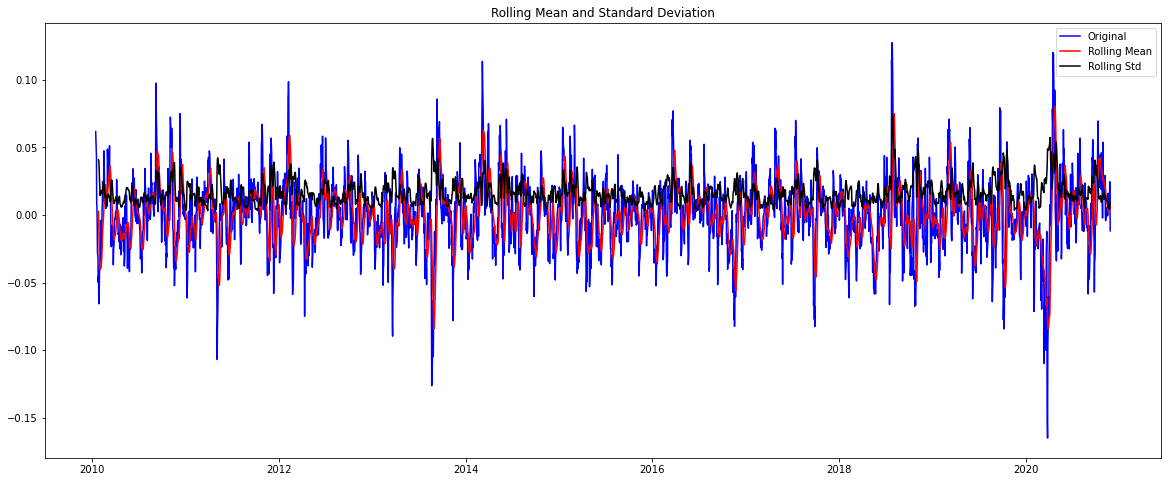

Results of dickey fuller test
Test Statistics                   -13.1515
p-value                        1.36409e-24
No. of lags used                        17
Number of observations used           3950
critical value (1%)              -3.432007
critical value (5%)              -2.862272
critical value (10%)             -2.567160
dtype: object


In [16]:
test_stationarity(X_logscale_minus_moving_average)

This seems to be the best so far with the with a very low p-value and a test statistic fitting above 1% critical value.

<a id = Section8></a>
# 8. Exponential Decay Transformation

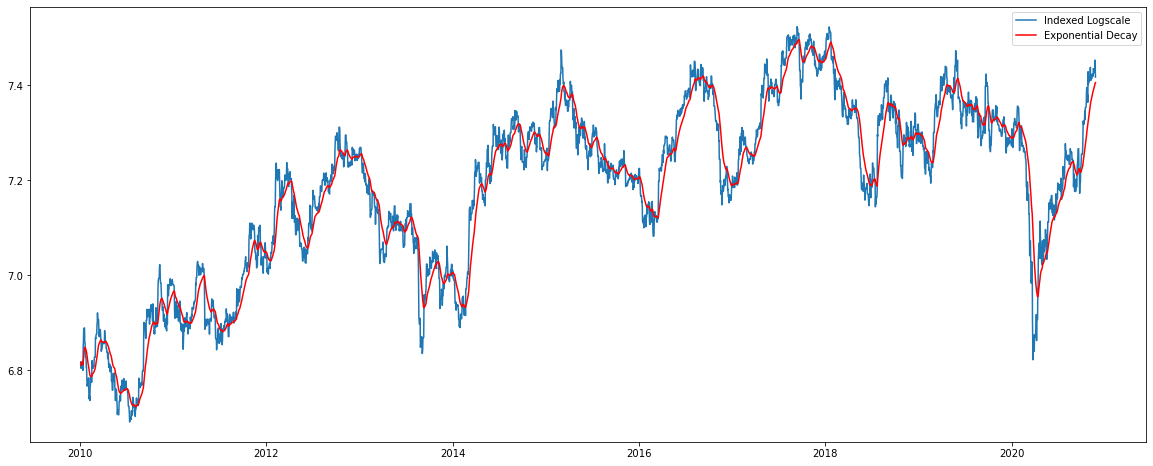

In [17]:
exponential_decay_weighted_average = X_index_logscale.ewm(halflife= 12).mean()  #exponential weighted with mean
plt.figure(figsize=(20,8))
plt.plot(X_index_logscale, label = 'Indexed Logscale')
plt.plot(exponential_decay_weighted_average, color = 'red', label = 'Exponential Decay')
plt.legend()

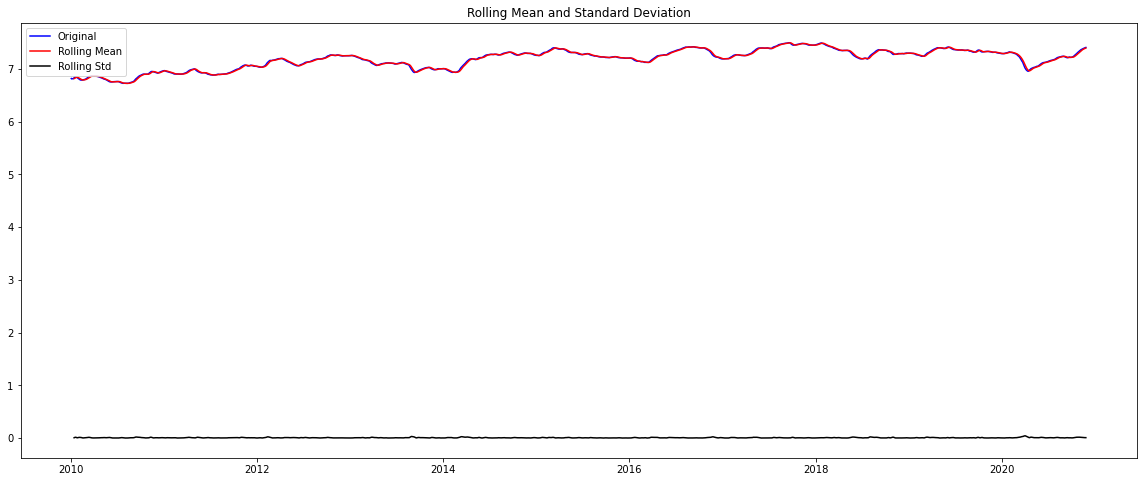

Results of dickey fuller test
Test Statistics                 -2.85762
p-value                         0.050503
No. of lags used                       1
Number of observations used         3977
critical value (1%)            -3.431995
critical value (5%)            -2.862267
critical value (10%)           -2.567157
dtype: object


In [18]:
test_stationarity(exponential_decay_weighted_average)

Clearly not as good as the logscale minus moving average.

<a id = Section9></a>
# 9. Logscale Minus Moving Average Transformation

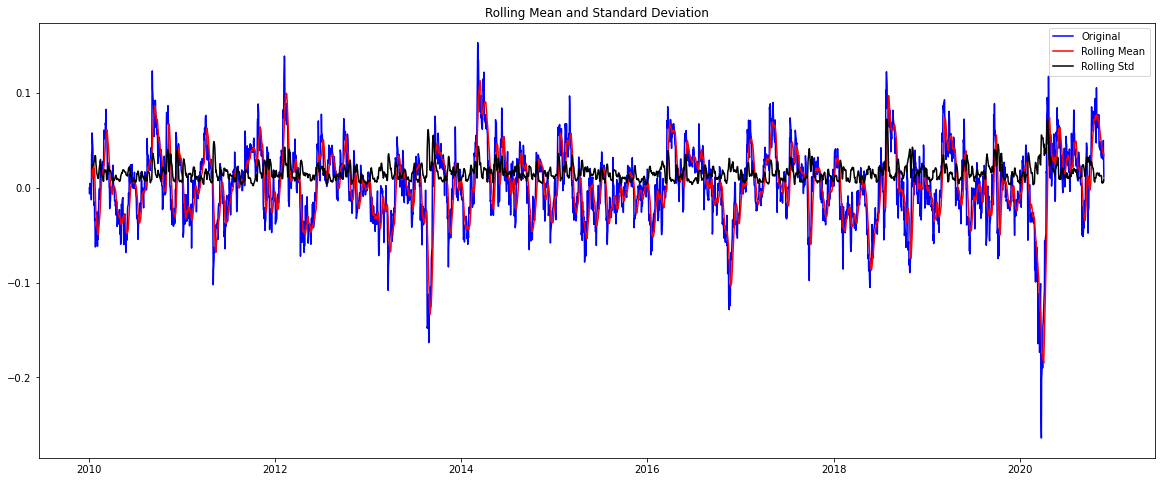

Results of dickey fuller test
Test Statistics                   -10.8318
p-value                        1.70072e-19
No. of lags used                         0
Number of observations used           3978
critical value (1%)              -3.431995
critical value (5%)              -2.862267
critical value (10%)             -2.567157
dtype: object


In [19]:
logscale_minus_moving_average = X_index_logscale - exponential_decay_weighted_average

test_stationarity(logscale_minus_moving_average)

Extremely good stationarity achieved but moving average transformation is the best yet.

<a id = Section10></a>
# 10. Time Shift Transformation

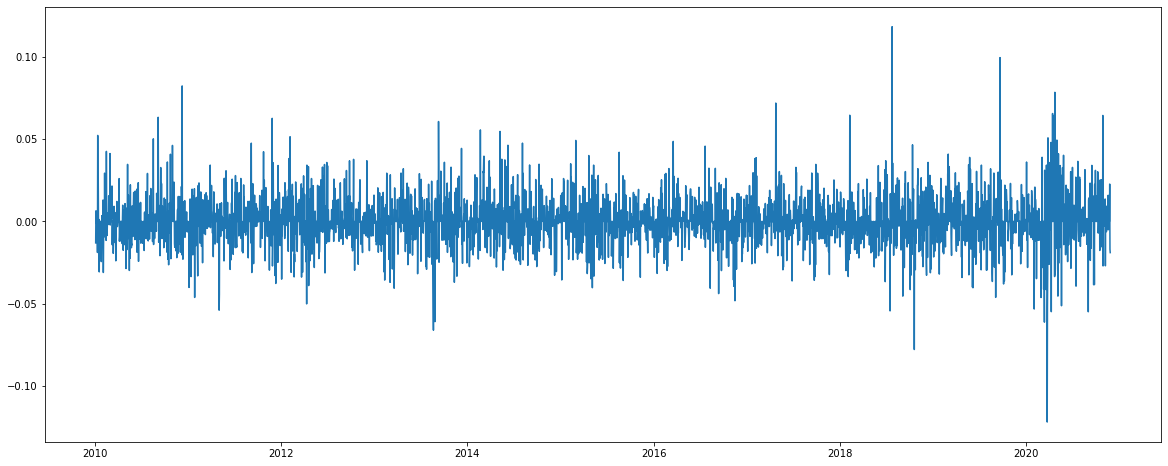

In [20]:
log_diff_shifting = X_index_logscale - X_index_logscale.shift()

plt.figure(figsize=(20,8))
plt.plot(log_diff_shifting)

log_diff_shifting.dropna(inplace = True)

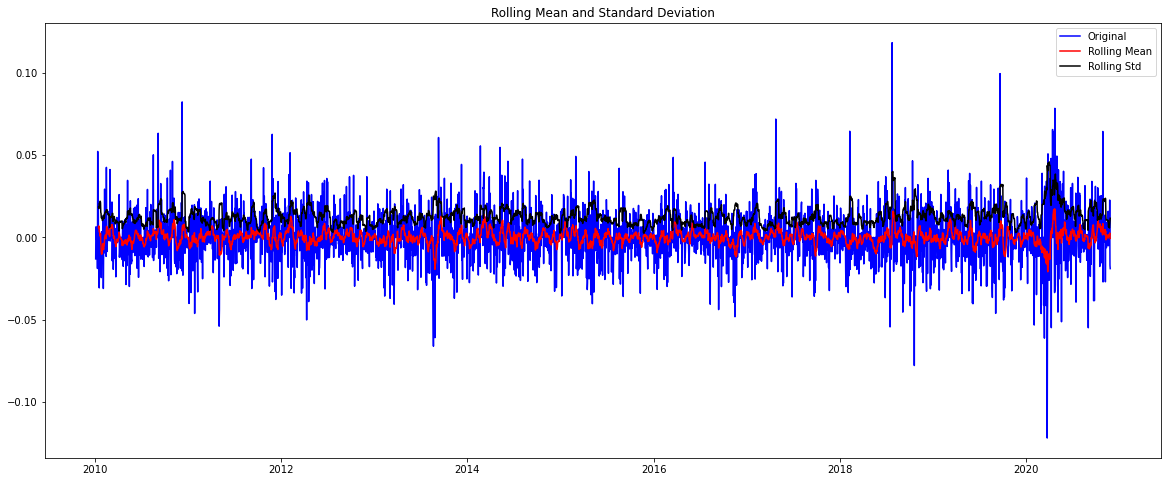

Results of dickey fuller test
Test Statistics                 -64.2779
p-value                                0
No. of lags used                       0
Number of observations used         3977
critical value (1%)            -3.431995
critical value (5%)            -2.862267
critical value (10%)           -2.567157
dtype: object


In [21]:
test_stationarity(log_diff_shifting)

Achieved even better stationarity than moving average transformation basis the Dickey Fuller test with low p-value and a test statistic better than 1%. We will proceed with the time-shift transformation for the rest of the calculations.

<a id = Section11></a>
# 11. Plotting ACF and PACF

E:\Data_Science\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


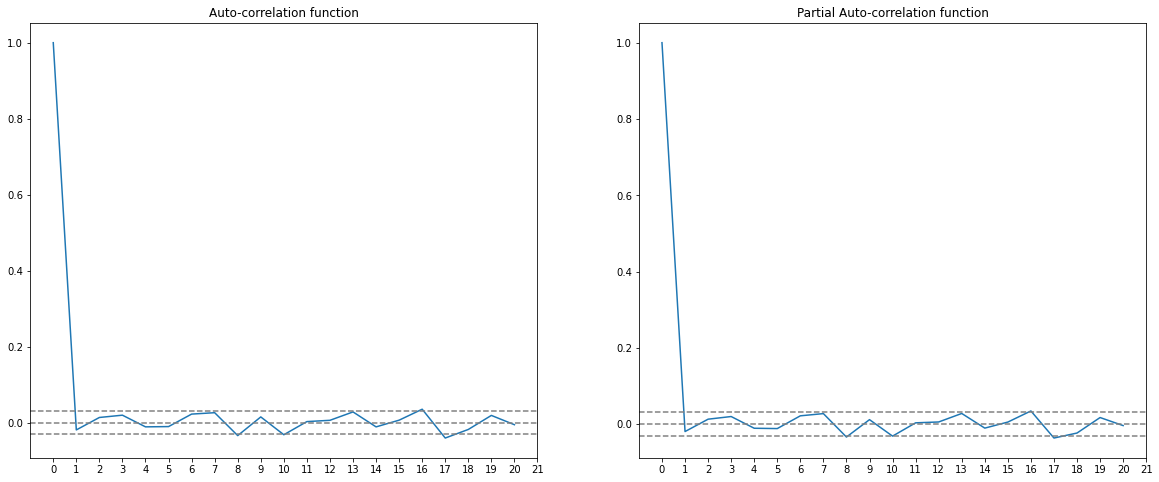

In [22]:
# Plotting ACF and PACF

lag_acf = acf(log_diff_shifting,nlags = 20)
lag_pacf = pacf(log_diff_shifting,nlags = 20, method = 'ols')

#plotting ACF
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff_shifting)), linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff_shifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,1))
plt.title('Auto-correlation function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(log_diff_shifting)), linestyle = '--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(log_diff_shifting)), linestyle = '--', color = 'gray')
plt.xticks(np.arange(0,22,1))
plt.title('Partial Auto-correlation function');

ACF --> Q = 1

PACF --> P = 1

<a id = Section12></a>
# 12. Building Models

In [23]:
#Train test split with last 30 days as the test set

train, test = log_diff_shifting[1:len(log_diff_shifting)-30] , log_diff_shifting[len(log_diff_shifting)-30:]

print('The training dataset is ', train.shape)
print(train.head())
print('The test dataset is ', test.shape)
print(test.head())

The training dataset is  (3947, 1)
               Close
Date                
2010-01-06  0.006466
2010-01-07  0.006315
2010-01-08 -0.001315
2010-01-09  0.000000
2010-01-10  0.000000
The test dataset is  (30, 1)
               Close
Date                
2020-10-27  0.064418
2020-10-28 -0.027058
2020-10-29  0.007901
2020-10-30 -0.001757
2020-10-31  0.000000


<a id = Section1201></a>
## 12.1 AR Model

In [24]:
# Getting the appropriate lag value

from statsmodels.tsa.ar_model import AR
ar = AR(train)
ar_model = ar.fit()
print('Lag: %s' % ar_model.k_ar)
print('Coefficients: %s' % ar_model.params)

Lag: 30
Coefficients: const        0.000156
L1.Close    -0.013034
L2.Close     0.013995
L3.Close     0.018324
L4.Close    -0.011321
L5.Close    -0.010391
L6.Close     0.022186
L7.Close     0.026596
L8.Close    -0.034569
L9.Close     0.010409
L10.Close   -0.029773
L11.Close    0.002233
L12.Close    0.010315
L13.Close    0.023491
L14.Close   -0.008728
L15.Close    0.007637
L16.Close    0.034567
L17.Close   -0.038483
L18.Close   -0.023057
L19.Close    0.015009
L20.Close   -0.003416
L21.Close   -0.018198
L22.Close   -0.032291
L23.Close    0.009989
L24.Close    0.027317
L25.Close   -0.008677
L26.Close   -0.006856
L27.Close    0.008550
L28.Close   -0.002683
L29.Close    0.004536
L30.Close   -0.004906
dtype: float64


E:\Data_Science\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


We note a lag of 30 as provided by the model.

In [25]:
pred = ar_model.predict(start = len(train), end = len(train)+ len(test)-1,dynamic = False)
pred.head()

2020-10-27    0.001819
2020-10-28   -0.000714
2020-10-29   -0.001527
2020-10-30   -0.000281
2020-10-31    0.000129
Freq: D, dtype: float64

In [26]:
#making predictions

pred = ar_model.predict(start = len(train), end = len(train)+len(test)-1, dynamic = False)
print(pred.head())
for i in range(len(pred)): 
    print('predicted=%f      , expected=%f' % (pred[i], test.iloc[i]) )

2020-10-27    0.001819
2020-10-28   -0.000714
2020-10-29   -0.001527
2020-10-30   -0.000281
2020-10-31    0.000129
Freq: D, dtype: float64
predicted=0.001819      , expected=0.064418
predicted=-0.000714      , expected=-0.027058
predicted=-0.001527      , expected=0.007901
predicted=-0.000281      , expected=-0.001757
predicted=0.000129      , expected=0.000000
predicted=0.001050      , expected=0.000000
predicted=-0.000187      , expected=0.010166
predicted=0.000281      , expected=-0.002735
predicted=0.000037      , expected=0.009018
predicted=0.000559      , expected=0.013656
predicted=0.001015      , expected=-0.026958
predicted=-0.001827      , expected=0.000000
predicted=-0.001579      , expected=0.000000
predicted=0.001820      , expected=0.009326
predicted=0.000103      , expected=-0.006248
predicted=-0.001880      , expected=0.006518
predicted=0.000582      , expected=0.002840
predicted=0.000764      , expected=0.000865
predicted=0.001032      , expected=-0.004964
predicted=-0

The mean squared error of the predicted from test is --> 0.0002509


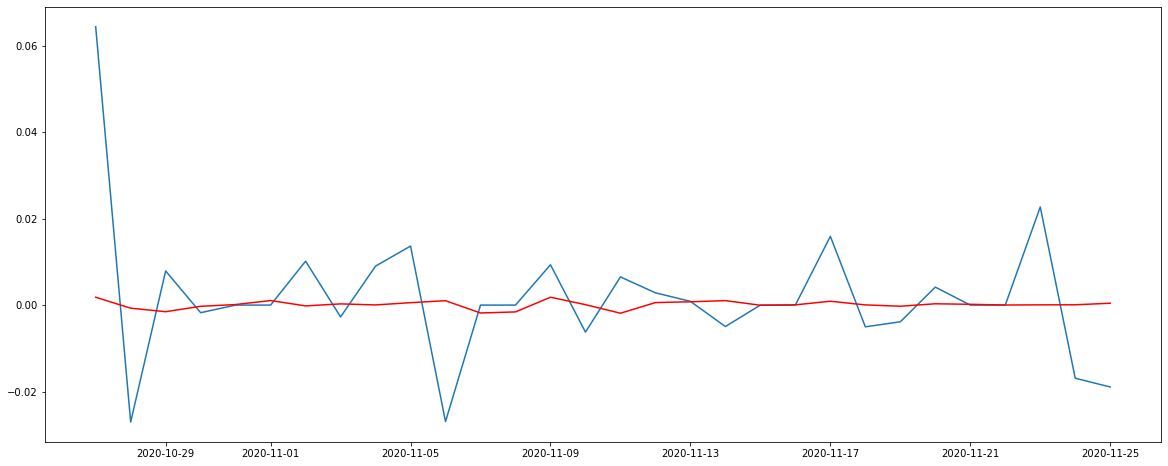

In [27]:
#checking for mean squared error

from sklearn.metrics import mean_squared_error
error = mean_squared_error(pred, test)
print('The mean squared error of the predicted from test is --> %.7f' % error)

#plotting the error
plt.figure(figsize=(20,8))
plt.plot(test)
plt.plot(pred, color = 'red')
plt.show()

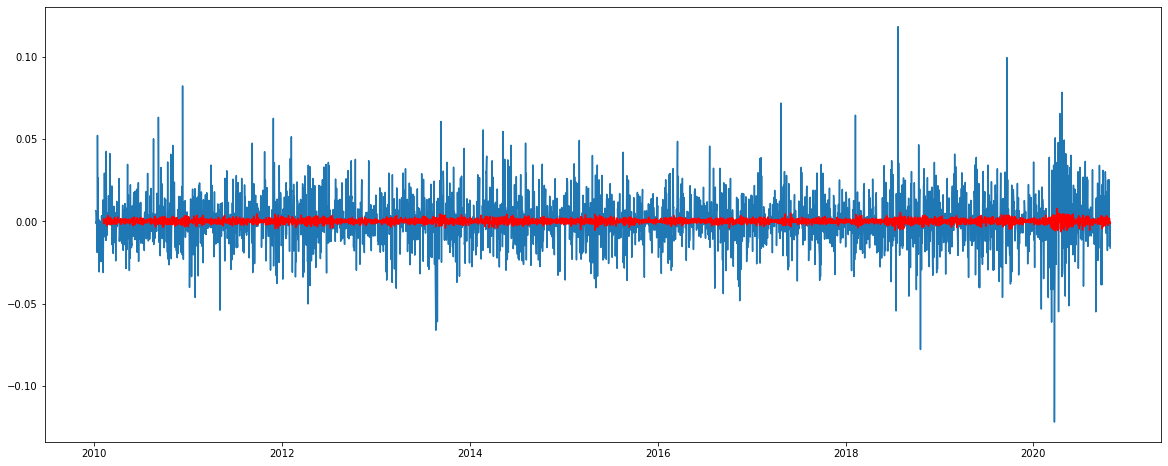

In [28]:
#plotting the AR model
plt.figure(figsize = (20,8))
plt.plot(train)
plt.plot(ar_model.fittedvalues, color = 'red');

<a id = Section1202></a>
## 12.2 ARMA Model

In [29]:
# the model throws error when instantiated with the order of (1,1)
from statsmodels.tsa.arima_model import ARMA
model = ARMA(train, order = (1,1))
arma_fit = model.fit()
print('Lags -->: %s' % arma_fit.k_ar)
print('Coefficients --> %s' % arma_fit.params)

Lags -->: 1
Coefficients --> const          0.000142
ar.L1.Close   -0.225812
ma.L1.Close    0.209927
dtype: float64


In [30]:
pred_arma = arma_fit.predict(start = len(train), end = len(train)+len(test)-1 , dynamic = False)
print(pred_arma.head())
for i in range(len(pred_arma)):
    print('predicted %.6f , expected %.6f' %(pred_arma[i],test.iloc[i]))

2020-10-27    0.000399
2020-10-28    0.000084
2020-10-29    0.000155
2020-10-30    0.000139
2020-10-31    0.000143
Freq: D, dtype: float64
predicted 0.000399 , expected 0.064418
predicted 0.000084 , expected -0.027058
predicted 0.000155 , expected 0.007901
predicted 0.000139 , expected -0.001757
predicted 0.000143 , expected 0.000000
predicted 0.000142 , expected 0.000000
predicted 0.000142 , expected 0.010166
predicted 0.000142 , expected -0.002735
predicted 0.000142 , expected 0.009018
predicted 0.000142 , expected 0.013656
predicted 0.000142 , expected -0.026958
predicted 0.000142 , expected 0.000000
predicted 0.000142 , expected 0.000000
predicted 0.000142 , expected 0.009326
predicted 0.000142 , expected -0.006248
predicted 0.000142 , expected 0.006518
predicted 0.000142 , expected 0.002840
predicted 0.000142 , expected 0.000865
predicted 0.000142 , expected -0.004964
predicted 0.000142 , expected 0.000000
predicted 0.000142 , expected 0.000000
predicted 0.000142 , expected 0.0159

The Mean Squared error on the test dataset is --> 0.00025585894840594804


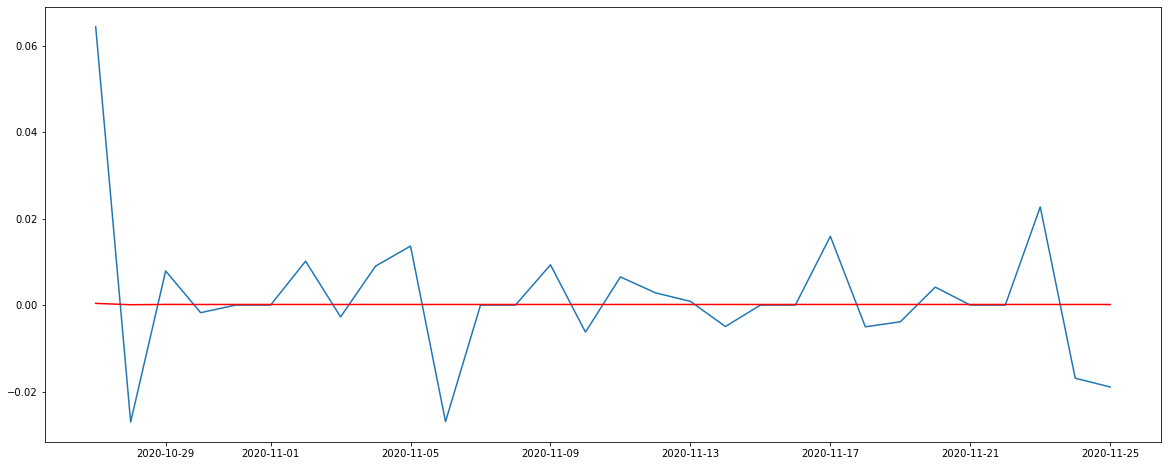

In [31]:
#plotting the predictions
print('The Mean Squared error on the test dataset is --> %s' % (mean_squared_error(pred_arma,test)))
plt.figure(figsize=(20,8))
plt.plot(test)
plt.plot(pred_arma, color = 'red');

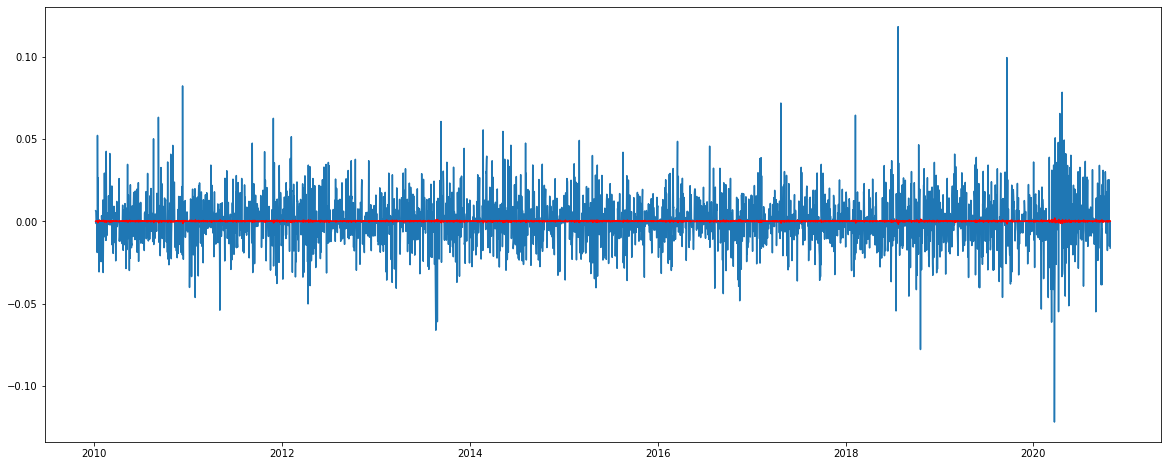

In [32]:
#plot = arma_fit.plot_predict()
plt.figure(figsize=(20,8))
plt.plot(train)
plt.plot(arma_fit.fittedvalues , color = 'red');

<a id = Section1203></a>
## 12.3 Arima Model

In [33]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(log_diff_shifting, order = (1,0,1))
arima_fit = arima.fit()
print('Lags --> %s' % arima_fit.k_ar)
print('Coefficients --> %s' % arima_fit.params)

Lags --> 1
Coefficients --> const          0.000151
ar.L1.Close   -0.221629
ma.L1.Close    0.201393
dtype: float64


In [34]:
# checking for error
error = mean_squared_error(log_diff_shifting, arima_fit.fittedvalues)
print('The mean squared error for predictions is --> %.6f ' % error)

The mean squared error for predictions is --> 0.000195 


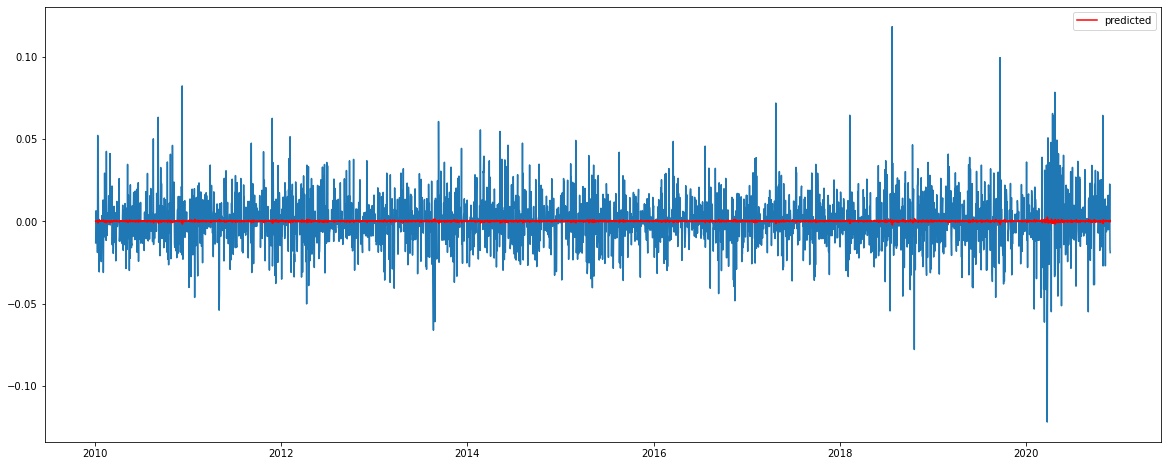

In [35]:
# plotting the data and predictions
plt.figure(figsize=(20,8))
plt.plot(log_diff_shifting)
plt.plot(arima_fit.fittedvalues, color = 'red', label = 'predicted')
plt.legend();

The arima model output seems very similar to the AR model output

<a id = Section13></a>
# 13. Prediction and reverse transformation of fitted values

In [36]:
pred_arima_diff = pd.Series(arima_fit.fittedvalues, copy = True)
pred_arima_diff.head()

Date
2010-01-05    0.000151
2010-01-06    0.000419
2010-01-07   -0.000031
2010-01-08    0.000063
2010-01-09    0.000198
Freq: D, dtype: float64

In [37]:
#removing moving average
pred_arima_diff_cumsum = pred_arima_diff.cumsum()
pred_arima_diff_cumsum.head()

Date
2010-01-05    0.000151
2010-01-06    0.000570
2010-01-07    0.000539
2010-01-08    0.000602
2010-01-09    0.000801
Freq: D, dtype: float64

In [38]:
pred_arima_log = pd.Series(X_index_logscale['Close'].iloc[0], index = log_diff_shifting.index )
pred_arima_log = pred_arima_log.add(pred_arima_diff_cumsum,fill_value=0)
pred_arima_log.tail()

Date
2020-11-21    7.417046
2020-11-22    7.417218
2020-11-23    7.417368
2020-11-24    7.417063
2020-11-25    7.417651
Freq: D, dtype: float64

In [39]:
#removing log effect
back_pred = pd.Series(np.exp(pred_arima_log))
back_pred.tail()

Date
2020-11-21    1664.110737
2020-11-22    1664.397411
2020-11-23    1664.646623
2020-11-24    1664.138359
2020-11-25    1665.117680
Freq: D, dtype: float64

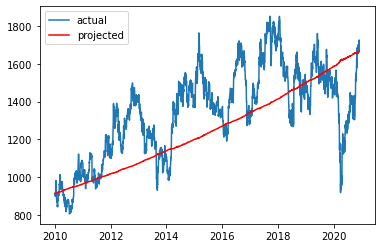

In [40]:
plt.plot(Xindex, label = 'actual')
plt.plot(back_pred, color = 'red', label = 'projected')
plt.legend()

Producing a straight line between start and close.  Maybe use a different model.

<a id = Section14></a>
# 14. Approach 2 for model building using Gridsearch

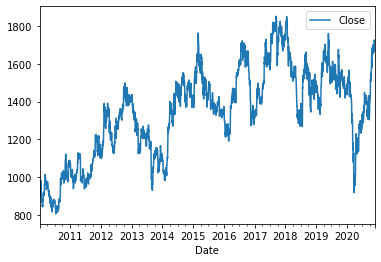

In [41]:
# for ARIMA model getting (p,d,q)

Xindex.plot(style = '-')

In [42]:
# using resample to get all dates and then forward filling with mean value to include all holidays as well
Xindex2 = Xindex.resample('D').mean().ffill()
Xindex2.tail()

Close
Date               
2020-11-21  1686.80
2020-11-22  1686.80
2020-11-23  1725.55
2020-11-24  1696.60
2020-11-25  1664.75

In [43]:
# Define the p, d and q parameters to take any value between 0 and 3
import itertools    #importing itertools to iterate through the different versions for p,d,q through gridsearch
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))   # Generate all different combinations of p, q and q

In [44]:
#using the training data set to check for (p,d & q) using grid search
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
aic= []
parameters = []
for param in pdq:  #for param in pdq:
    try:
        mod = SARIMAX(Xindex2, order=param, enforce_stationarity=True, enforce_invertibility=True,n_jobs = -1)
        
        results = mod.fit()
        aic.append(results.aic) # save results in lists
        parameters.append(param)
        seasonal_param.append(param_seasonal)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue
# find lowest aic          
index_min = min(range(len(aic)), key=aic.__getitem__)           
 
print('The optimal model is: ARIMA{} -AIC {}'.format(parameters[index_min], aic[index_min]))

The optimal model is: ARIMA(2, 1, 2) -AIC 34566.86388872792


Optimal Model is:

p--> 2
d--> 1
q--> 2

In [45]:
model = ARIMA(Xindex2, order=parameters[index_min])
model_fit = model.fit(display = 0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3978
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -17278.225
Method:                       css-mle   S.D. of innovations             18.625
Date:                Thu, 26 Nov 2020   AIC                          34568.449
Time:                        09:50:04   BIC                          34606.180
Sample:                    01-05-2010   HQIC                         34581.828
                         - 11-25-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1889      0.293      0.644      0.520      -0.386       0.764
ar.L1.D.Close     0.0410      0.016      2.646      0.008       0.011       0.071
ar.L2.D.Close    -0.9666      0.021    -

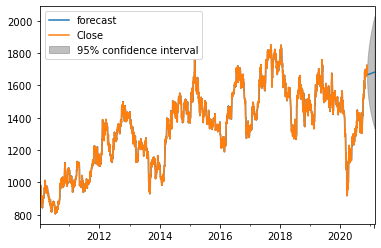

In [46]:
fig = model_fit.plot_predict(start=2, end=len(Xindex2)+90)
plt.show();

Seems expected to grow marginally least in the next 90 day period.

The predicted rise in   stock value of  ACC    0.0230158
dtype: object %


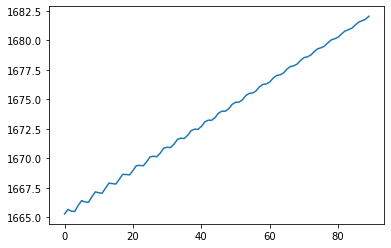

In [47]:
forecast = model_fit.forecast(steps = 90)
prediction = pd.DataFrame(forecast).T
prediction.drop(columns = [1,2], inplace=True)
prediction.rename(columns = {0: 'ACC'}, inplace = True)

print('The predicted rise in ',' stock value of ', ((prediction.iloc[1]-prediction.iloc[0])/prediction.iloc[0])*100,'%')

plt.plot(prediction)

<a id = Section15></a>
# 15. Approach 3 for model building -  Using facebook Prophet

In [48]:
X.tail()

Date    Close
2704 2020-11-19  1679.80
2705 2020-11-20  1686.80
2706 2020-11-23  1725.55
2707 2020-11-24  1696.60
2708 2020-11-25  1664.75

In [49]:
from fbprophet import Prophet

X.columns = ['ds', 'y']
# converting the data to prophet format
X.tail(n=3)

ds        y
2706 2020-11-23  1725.55
2707 2020-11-24  1696.60
2708 2020-11-25  1664.75

In [50]:
#removing the last 30 days worth of data from the training set

prediction_size = 90
train = X[:-prediction_size]
train.tail()

ds        y
2614 2020-07-15  1287.00
2615 2020-07-16  1299.90
2616 2020-07-17  1315.85
2617 2020-07-20  1329.80
2618 2020-07-21  1379.25

In [51]:
# fitting the Prophet model (m)
m = Prophet()
m.fit(train);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<a id = Section1501></a>
## 15.1 Prediction

In [52]:
#now making the future dataframe dates

future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=3)

ds
2703 2020-10-17
2704 2020-10-18
2705 2020-10-19

In [53]:
#predicted values with in-sample fit for the history

forecast = m.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
2701 2020-10-15  1321.143705  1209.009738  1466.841387  1312.557209   
2702 2020-10-16  1320.854732  1204.747309  1470.518027  1312.149692   
2703 2020-10-17  1320.565760  1239.111652  1505.946497  1311.613369   
2704 2020-10-18  1320.276788  1215.225924  1482.405467  1311.145210   
2705 2020-10-19  1319.987815  1211.773707  1468.106786  1310.572457   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
2701  1330.113717       17.049893             17.049893             17.049893   
2702  1329.989451       17.444839             17.444839             17.444839   
2703  1329.853621       55.287530             55.287530             55.287530   
2704  1329.740078       30.584386             30.584386             30.584386   
2705  1330.056586       20.330843             20.330843             20.330843   

         weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
2701  -5.678711     -5.678711     -5.678711  22.728604     22.728604   
2702  -6.139238     -6.139238     -6.139238  23.584077     23.584077   
2703  30.648815     30.648815     30.648815  24.638715     24.638715   
2704   4.718187      4.718187      4.718187  25.866199     25.866199   
2705  -6.904455     -6.904455     -6.904455  27.235298     27.235298   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
2701     22.728604                   0.0                         0.0   
2702     23.584077                   0.0                         0.0   
2703     24.638715                   0.0                         0.0   
2704     25.866199                   0.0                         0.0   
2705     27.235298                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
2701                         0.0  1338.193598  
2702                         0.0  1338.299571  
2703                         0.0  1375.853290  
2704                         0.0  1350.861174  
2705                         0.0  1340.318658

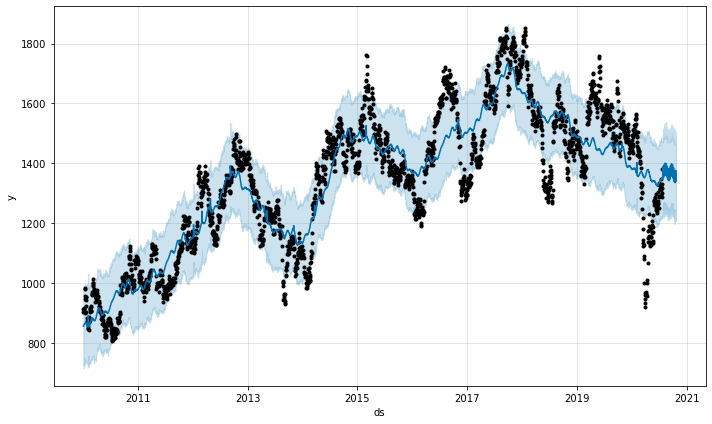

In [54]:
#checking the fit of the model with actual data - using prophet's buit in visualisation system

m.plot(forecast);

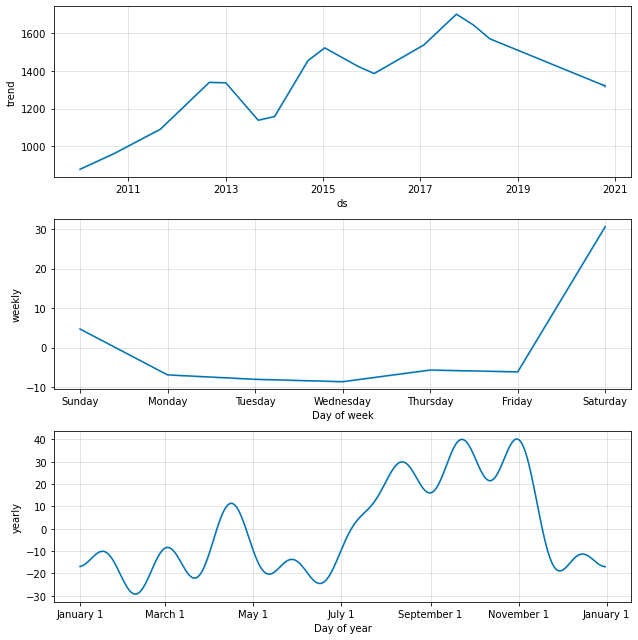

In [55]:
# taking a look at the different components:

m.plot_components(forecast);

<a id = Section1502></a>
## 15.2 Model Evaluation

In [56]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [57]:
#function to join predicted values with historical values

def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [58]:
pred = make_comparison_dataframe(X, forecast)
pred

yhat   yhat_lower   yhat_upper        y
ds                                                        
2010-01-04   855.492015   722.785989   986.605106   913.60
2010-01-05   855.141452   732.278369   979.671625   901.75
2010-01-06   855.378579   729.295812   988.835573   907.60
2010-01-07   859.224730   713.705052   976.080043   913.35
2010-01-08   859.705973   723.144902   981.202720   912.15
...                 ...          ...          ...      ...
2020-10-15  1338.193598  1209.009738  1466.841387  1522.40
2020-10-16  1338.299571  1204.747309  1470.518027  1561.15
2020-10-17  1375.853290  1239.111652  1505.946497      NaN
2020-10-18  1350.861174  1215.225924  1482.405467      NaN
2020-10-19  1340.318658  1211.773707  1468.106786  1562.65

[2709 rows x 4 columns]

In [59]:
#Calculating mean absolute percentage error and mean absolute error by creating a function

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()  # making a copy of the dataset
    
    df['e'] = df['y'] - df['yhat']  #differencing actual versus predicted
    df['p'] = 100 * df['e'] / df['y'] # calculating the percentage error
    
    predicted_part = df[-prediction_size:]   #removing the portion for which we made our predictions
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))  #absolute error over predicted part
    return {'MAPE % ': error_mean('p'), 'MAE': error_mean('e')} #return MAPE and MAE

In [60]:
#running the function
for err_name, err_value in calculate_forecast_errors(pred, prediction_size).items():
    print(err_name, err_value)

MAPE %  4.198189466908816
MAE 61.016599192344536


<a id = Section16></a>
# 16. Conclusion and Way Forward

Many people have tried to predict stock movement for profit.  However it is a difficult task.  The objective of this exercise was provide better than average returns - as compared to investing directly in NIFTY.  I believe this tool can help in this objective.

We see that different methods provide different outputs - in fact the automated method using gridsearch to identify (p,d,q) provides divergent results as compared to FB Prophet.  The output from FB Prophet - on ACC stock says that it should be operating at a lower level.

The way forward would be to look at the whole basket of stocks (as created from yahoo finance) and then consider those which are projected to have the highest rise in stock prices in the near future - say 7-10 day intervals and run accordingly - using the automated gridsearch or FB Prophet method.

This would need to be implemented in the real world to see what sort of value it can provide.  I look forward to spending more time on this project to improve the analytic and build a system to take all stocks into account - though the time taken to extract individually all historical stock data would be extremely time consuming.  Maybe a possibility to create a csv file with all historical data and then only update today's date data, effectively using that to project stock prices.